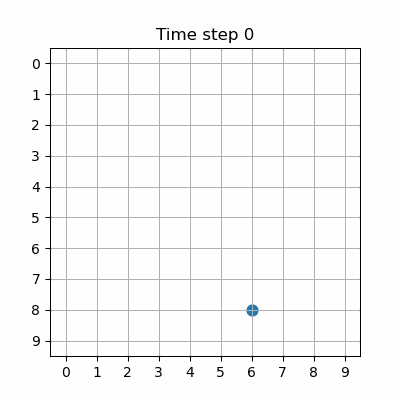

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import Image, display

# -----------------------
# Setup (same idea as yours)
# -----------------------
H, W = 10, 10
m = 1
T = 12
rng = np.random.default_rng(0)

Omega_rc = np.column_stack([
    rng.integers(0, H, size=m),
    rng.integers(0, W, size=m)
])

def move_policy(Omega_rc, t, H, W):
    # move down by 1, clamp at bottom
    return np.column_stack([
        np.clip(Omega_rc[:, 0] + 1, 0, H - 1),
        Omega_rc[:, 1],
    ])

# collect positions over time
positions = []
for t in range(T + 1):
    positions.append(Omega_rc.copy())
    Omega_rc = move_policy(Omega_rc, t, H, W)

# -----------------------
# Animate + save GIF
# -----------------------
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlim(-0.5, W - 0.5)
ax.set_ylim(H - 0.5, -0.5)
ax.set_xticks(range(W))
ax.set_yticks(range(H))
ax.grid(True)

scat = ax.scatter([], [], s=60)

def init():
    scat.set_offsets(np.empty((0, 2)))
    return (scat,)

def update(frame):
    Omega = positions[frame]
    xy = np.column_stack([Omega[:, 1], Omega[:, 0]])  # x=col, y=row
    scat.set_offsets(xy)
    ax.set_title(f"Time step {frame}")
    return (scat,)

ani = animation.FuncAnimation(
    fig, update, frames=len(positions), init_func=init, interval=500, blit=True
)

gif_path = "robot_movement.gif"
ani.save(gif_path, writer=animation.PillowWriter(fps=2))
plt.close(fig)

display(Image(filename=gif_path))


In [13]:
import numpy as np

m = 1
H, W = 10, 10
rng = np.random.default_rng(0)

Omega_rc = np.column_stack([
    rng.integers(0, H, size=m),
    rng.integers(0, W, size=m)
])

print(Omega_rc)

def rc_to_idx(r, c):
    return r * W + c

def selector_from_rc(Omega_rc, H, W):
    n = H * W
    m = Omega_rc.shape[0]
    P = np.zeros((m, n))
    for row, (r, c) in enumerate(Omega_rc):
        idx = rc_to_idx(r, c)
        P[row, idx] = 1.0
    return P

# system
G = rng.normal(scale=0.15, size=(n, n))
v0_true = rng.normal(size=(n,))
v0_true = v0_true / np.linalg.norm(v0_true)

'''
# sensors initial (in 2D)
Omega_rc = np.array([
    [0, 0],
    [5, 5],
    [9, 2],
])
'''

O_blocks = []
ys = []
v_t = v0_true.copy()
G_power = np.eye(n)
noise_level = 0


for t in range(T+1):
    
    
    '''adding visul'''
    P_t = selector_from_rc(Omega_rc, H, W)
    # measurement
    y_t = P_t @ v_t + rng.normal(scale=noise_level, size=(m,))
    ys.append(y_t)

    if t == 0:
        O_blocks.append(P_t @ G_power)
    else:
        G_power = G_power @ G
        O_blocks.append(P_t @ G_power)
        
    v_t = G @ v_t
    # ask Dr. S
    Omega_rc = np.column_stack([
        np.clip(Omega_rc[:, 0] + 1, 0, H-1),   # rows go down
        Omega_rc[:, 1],                        # cols stay
    ])

# stack
y_stacked = np.concatenate(ys, axis=0)
O_T = np.vstack(O_blocks)

# reconstruct
v0_hat, *_ = np.linalg.lstsq(O_T, y_stacked, rcond=None)
err = np.linalg.norm(v0_hat - v0_true)
print("error:", err)
print("rank(O_T):", np.linalg.matrix_rank(O_T))


[[8 6]
 [6 9]
 [5 5]
 [2 6]
 [3 9]
 [0 7]
 [0 6]
 [0 5]
 [1 5]
 [8 9]]
error: 0.15025830462792206
rank(O_T): 94


| Movement | Number of<br> Sensors | Time step |Parameter| O_t Rank | Reconstruction<br>Error
|:----------:|:----------:|:----------:|:----------:|:----------:|:----------:|
|Streight Down|1|10|None|11|0.92|
|Straight Down|3|10|None|33|0.82|
|Staitionary|1|10|None|11|0.94|
|Staitionary|1|100|None|38|0.81|
|Staitionary|3|10|None|33|0.81|
|Staitionary|5|10|None|55|0.70|
|**Staitionary**|5|50|None|100|~0|
|Diagonal|1|10|None|3|0.81|
|Brute (Reveresed)|2|100|None|39|0.81|
|Serpentine|2|50|None|95|~0|
|**Serpentine**|5|50|None|100|~0|
|Random Walk|5|100|None|38|0.81
|**Random Walk**|5|50|None|100|~0
|**Random Walk**|10|10|None|100|~0




### One Sensor Moving in the Middle

Initial Omega_rc: [[0 5]]
Reconstruction error: 0.9283641073658385
rank(O_T): 11


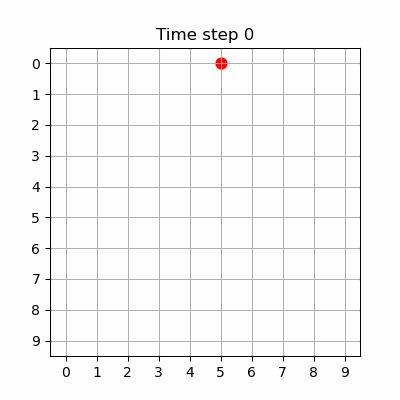

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import Image, display

# -----------------------
# Parameters
# -----------------------
np.random.seed(10)

H, W = 10, 10
n = H * W
m = 1
T = 10
noise_level = 0

rng = np.random.default_rng(0)

# -----------------------
# Initial robot position
# -----------------------
Omega_rc = np.array([
    [0, 5],
])
m = Omega_rc.shape[0]


print("Initial Omega_rc:", Omega_rc)

# -----------------------
# Helper functions
# -----------------------
def rc_to_idx(r, c):
    return r * W + c

def selector_from_rc(Omega_rc, H, W):
    n = H * W
    m = Omega_rc.shape[0]
    P = np.zeros((m, n))
    for row, (r, c) in enumerate(Omega_rc):
        idx = rc_to_idx(r, c)
        P[row, idx] = 1.0
    return P

def move_policy(Omega_rc, t, H, W):
    # move down by 1, saturate at bottom
    return np.column_stack([
        np.clip(Omega_rc[:, 0] + 1, 0, H - 1),
        Omega_rc[:, 1],
    ])

# -----------------------
# System definition
# -----------------------
G = rng.normal(scale=0.15, size=(n, n))

v0_true = rng.normal(size=n)
v0_true /= np.linalg.norm(v0_true)

# -----------------------
# Storage
# -----------------------
O_blocks = []
ys = []
positions = []

v_t = v0_true.copy()
G_power = np.eye(n)

# -----------------------
# Simulation loop
# -----------------------
for t in range(T + 1):

    # store robot position (for visualization)
    positions.append(Omega_rc.copy())

    # selector matrix
    P_t = selector_from_rc(Omega_rc, H, W)

    # measurement
    y_t = P_t @ v_t + rng.normal(scale=noise_level, size=m)
    ys.append(y_t)

    # observability block
    if t == 0:
        O_blocks.append(P_t @ G_power)
    else:
        G_power = G_power @ G
        O_blocks.append(P_t @ G_power)

    # system evolution
    v_t = G @ v_t

    # robot motion
    Omega_rc = move_policy(Omega_rc, t, H, W)

# -----------------------
# Stack & reconstruct
# -----------------------
y_stacked = np.concatenate(ys, axis=0)
O_T = np.vstack(O_blocks)

v0_hat, *_ = np.linalg.lstsq(O_T, y_stacked, rcond=None)

err = np.linalg.norm(v0_hat - v0_true)

print("Reconstruction error:", err)
print("rank(O_T):", np.linalg.matrix_rank(O_T))

# -----------------------
# Visualization (GIF)
# -----------------------
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlim(-0.5, W - 0.5)
ax.set_ylim(H - 0.5, -0.5)
ax.set_xticks(range(W))
ax.set_yticks(range(H))
ax.grid(True)

scat = ax.scatter([], [], s=60, c="red")

def init():
    scat.set_offsets(np.empty((0, 2)))
    return (scat,)

def update(frame):
    Omega = positions[frame]
    xy = np.column_stack([Omega[:, 1], Omega[:, 0]])  # (x=col, y=row)
    scat.set_offsets(xy)
    ax.set_title(f"Time step {frame}")
    return (scat,)

ani = animation.FuncAnimation(
    fig,
    update,
    frames=len(positions),
    init_func=init,
    interval=500,
    blit=True
)

gif_path = "robot_movement.gif"
ani.save(gif_path, writer=animation.PillowWriter(fps=2))
plt.close(fig)

display(Image(filename=gif_path))


### 3 Sensor Moving down

Initial Omega_rc: [[0 0]
 [0 5]
 [0 9]]
Reconstruction error: 0.8299520709724315
rank(O_T): 33


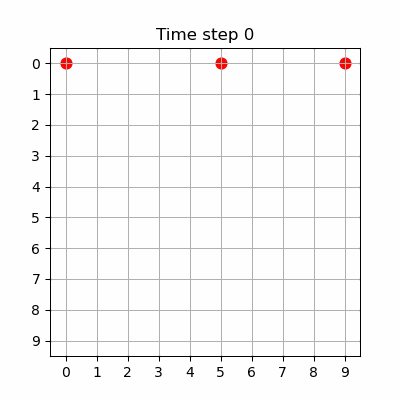

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import Image, display

# -----------------------
# Parameters
# -----------------------
H, W = 10, 10
n = H * W
T = 10
noise_level = 0

rng = np.random.default_rng(0)

# -----------------------
# Initial robot position
# -----------------------
Omega_rc = np.array([
    [0, 0],    
    [0, 5],
    [0, 9],
])
m = Omega_rc.shape[0]


print("Initial Omega_rc:", Omega_rc)

# -----------------------
# Helper functions
# -----------------------
def rc_to_idx(r, c):
    return r * W + c

def selector_from_rc(Omega_rc, H, W):
    n = H * W
    m = Omega_rc.shape[0]
    P = np.zeros((m, n))
    for row, (r, c) in enumerate(Omega_rc):
        idx = rc_to_idx(r, c)
        P[row, idx] = 1.0
    return P

def move_policy(Omega_rc, t, H, W):
    # move down by 1, saturate at bottom
    return np.column_stack([
        np.clip(Omega_rc[:, 0] + 1, 0, H - 1),
        Omega_rc[:, 1],
    ])

# -----------------------
# System definition
# -----------------------
G = rng.normal(scale=0.15, size=(n, n))

v0_true = rng.normal(size=n)
v0_true /= np.linalg.norm(v0_true)

# -----------------------
# Storage
# -----------------------
O_blocks = []
ys = []
positions = []

v_t = v0_true.copy()
G_power = np.eye(n)

# -----------------------
# Simulation loop
# -----------------------
for t in range(T + 1):

    # store robot position (for visualization)
    positions.append(Omega_rc.copy())

    # selector matrix
    P_t = selector_from_rc(Omega_rc, H, W)

    # measurement
    y_t = P_t @ v_t + rng.normal(scale=noise_level, size=m)
    ys.append(y_t)

    # observability block
    if t == 0:
        O_blocks.append(P_t @ G_power)
    else:
        G_power = G_power @ G
        O_blocks.append(P_t @ G_power)

    # system evolution
    v_t = G @ v_t

    # robot motion
    Omega_rc = move_policy(Omega_rc, t, H, W)

# -----------------------
# Stack & reconstruct
# -----------------------
y_stacked = np.concatenate(ys, axis=0)
O_T = np.vstack(O_blocks)

v0_hat, *_ = np.linalg.lstsq(O_T, y_stacked, rcond=None)

err = np.linalg.norm(v0_hat - v0_true)

print("Reconstruction error:", err)
print("rank(O_T):", np.linalg.matrix_rank(O_T))

# -----------------------
# Visualization (GIF)
# -----------------------
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlim(-0.5, W - 0.5)
ax.set_ylim(H - 0.5, -0.5)
ax.set_xticks(range(W))
ax.set_yticks(range(H))
ax.grid(True)

scat = ax.scatter([], [], s=60, c="red")

def init():
    scat.set_offsets(np.empty((0, 2)))
    return (scat,)

def update(frame):
    Omega = positions[frame]
    xy = np.column_stack([Omega[:, 1], Omega[:, 0]])  # (x=col, y=row)
    scat.set_offsets(xy)
    ax.set_title(f"Time step {frame}")
    return (scat,)

ani = animation.FuncAnimation(
    fig,
    update,
    frames=len(positions),
    init_func=init,
    interval=500,
    blit=True
)

gif_path = "robot_movement.gif"
ani.save(gif_path, writer=animation.PillowWriter(fps=2))
plt.close(fig)

display(Image(filename=gif_path))


### One sensor Stationary

Initial Omega_rc: [[5 5]]
Reconstruction error: 0.9444295305912825
rank(O_T): 11


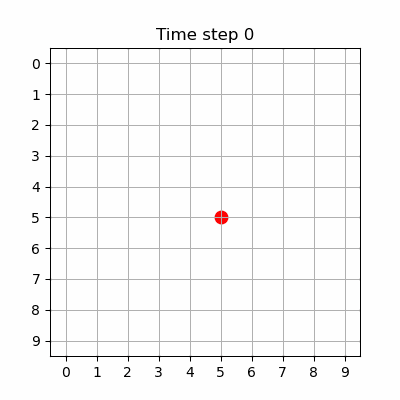

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import Image, display

# -----------------------
# Parameters
# -----------------------
H, W = 10, 10
n = H * W
T = 10
noise_level = 0

rng = np.random.default_rng(0)

Omega_rc = np.array([
    [H // 2,     W // 2],
])

m = Omega_rc.shape[0]

print("Initial Omega_rc:", Omega_rc)

# -----------------------
# Helper functions
# -----------------------
def rc_to_idx(r, c):
    return r * W + c

def selector_from_rc(Omega_rc, H, W):
    n = H * W
    m = Omega_rc.shape[0]
    P = np.zeros((m, n))
    for row, (r, c) in enumerate(Omega_rc):
        idx = rc_to_idx(r, c)
        P[row, idx] = 1.0
    return P

def move_policy(Omega_rc, t, H, W):
    """
    Static policy:
    Robots do NOT move.
    """
    return Omega_rc.copy()

# -----------------------
# System definition
# -----------------------
G = rng.normal(scale=0.15, size=(n, n))

v0_true = rng.normal(size=n)
v0_true /= np.linalg.norm(v0_true)

# -----------------------
# Storage
# -----------------------
O_blocks = []
ys = []
positions = []

v_t = v0_true.copy()
G_power = np.eye(n)

# -----------------------
# Simulation loop
# -----------------------
for t in range(T + 1):

    # store robot positions (for visualization)
    positions.append(Omega_rc.copy())

    # selector matrix
    P_t = selector_from_rc(Omega_rc, H, W)

    # measurement
    y_t = P_t @ v_t + rng.normal(scale=noise_level, size=m)
    ys.append(y_t)

    # observability block
    if t == 0:
        O_blocks.append(P_t @ G_power)
    else:
        G_power = G_power @ G
        O_blocks.append(P_t @ G_power)

    # system evolution
    v_t = G @ v_t

    # robot motion (static)
    Omega_rc = move_policy(Omega_rc, t, H, W)

# -----------------------
# Stack & reconstruct
# -----------------------
y_stacked = np.concatenate(ys, axis=0)
O_T = np.vstack(O_blocks)

v0_hat, *_ = np.linalg.lstsq(O_T, y_stacked, rcond=None)
err = np.linalg.norm(v0_hat - v0_true)

print("Reconstruction error:", err)
print("rank(O_T):", np.linalg.matrix_rank(O_T))

# -----------------------
# Visualization (GIF)
# -----------------------
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlim(-0.5, W - 0.5)
ax.set_ylim(H - 0.5, -0.5)
ax.set_xticks(range(W))
ax.set_yticks(range(H))
ax.grid(True)

scat = ax.scatter([], [], s=80, c="red")

def init():
    scat.set_offsets(np.empty((0, 2)))
    return (scat,)

def update(frame):
    Omega = positions[frame]
    xy = np.column_stack([Omega[:, 1], Omega[:, 0]])  # (x=col, y=row)
    scat.set_offsets(xy)
    ax.set_title(f"Time step {frame}")
    return (scat,)

ani = animation.FuncAnimation(
    fig,
    update,
    frames=len(positions),
    init_func=init,
    interval=500,
    blit=True
)

gif_path = "robot_static.gif"
ani.save(gif_path, writer=animation.PillowWriter(fps=2))
plt.close(fig)

display(Image(filename=gif_path))


Initial Omega_rc: [[5 5]]
Reconstruction error: 0.8170032934102617
rank(O_T): 38


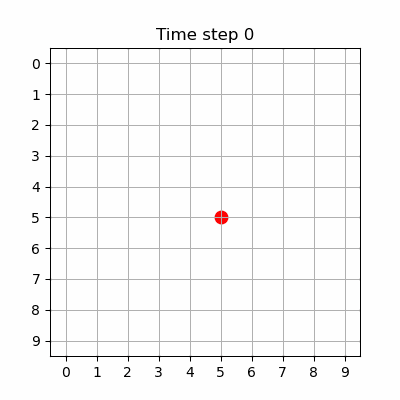

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import Image, display

# -----------------------
# Parameters
# -----------------------
H, W = 10, 10
n = H * W
T = 100
noise_level = 0

rng = np.random.default_rng(0)

Omega_rc = np.array([
    [H // 2,     W // 2],
])

m = Omega_rc.shape[0]

print("Initial Omega_rc:", Omega_rc)

# -----------------------
# Helper functions
# -----------------------
def rc_to_idx(r, c):
    return r * W + c

def selector_from_rc(Omega_rc, H, W):
    n = H * W
    m = Omega_rc.shape[0]
    P = np.zeros((m, n))
    for row, (r, c) in enumerate(Omega_rc):
        idx = rc_to_idx(r, c)
        P[row, idx] = 1.0
    return P

def move_policy(Omega_rc, t, H, W):
    """
    Static policy:
    Robots do NOT move.
    """
    return Omega_rc.copy()

# -----------------------
# System definition
# -----------------------
G = rng.normal(scale=0.15, size=(n, n))

v0_true = rng.normal(size=n)
v0_true /= np.linalg.norm(v0_true)

# -----------------------
# Storage
# -----------------------
O_blocks = []
ys = []
positions = []

v_t = v0_true.copy()
G_power = np.eye(n)

# -----------------------
# Simulation loop
# -----------------------
for t in range(T + 1):

    # store robot positions (for visualization)
    positions.append(Omega_rc.copy())

    # selector matrix
    P_t = selector_from_rc(Omega_rc, H, W)

    # measurement
    y_t = P_t @ v_t + rng.normal(scale=noise_level, size=m)
    ys.append(y_t)

    # observability block
    if t == 0:
        O_blocks.append(P_t @ G_power)
    else:
        G_power = G_power @ G
        O_blocks.append(P_t @ G_power)

    # system evolution
    v_t = G @ v_t

    # robot motion (static)
    Omega_rc = move_policy(Omega_rc, t, H, W)

# -----------------------
# Stack & reconstruct
# -----------------------
y_stacked = np.concatenate(ys, axis=0)
O_T = np.vstack(O_blocks)

v0_hat, *_ = np.linalg.lstsq(O_T, y_stacked, rcond=None)
err = np.linalg.norm(v0_hat - v0_true)

print("Reconstruction error:", err)
print("rank(O_T):", np.linalg.matrix_rank(O_T))

# -----------------------
# Visualization (GIF)
# -----------------------
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlim(-0.5, W - 0.5)
ax.set_ylim(H - 0.5, -0.5)
ax.set_xticks(range(W))
ax.set_yticks(range(H))
ax.grid(True)

scat = ax.scatter([], [], s=80, c="red")

def init():
    scat.set_offsets(np.empty((0, 2)))
    return (scat,)

def update(frame):
    Omega = positions[frame]
    xy = np.column_stack([Omega[:, 1], Omega[:, 0]])  # (x=col, y=row)
    scat.set_offsets(xy)
    ax.set_title(f"Time step {frame}")
    return (scat,)

ani = animation.FuncAnimation(
    fig,
    update,
    frames=len(positions),
    init_func=init,
    interval=500,
    blit=True
)

gif_path = "robot_static.gif"
ani.save(gif_path, writer=animation.PillowWriter(fps=2))
plt.close(fig)

display(Image(filename=gif_path))


### Three sensors Stationary

Initial Omega_rc: [[5 5]
 [4 5]
 [5 4]]
Reconstruction error: 0.810091661493017
rank(O_T): 33


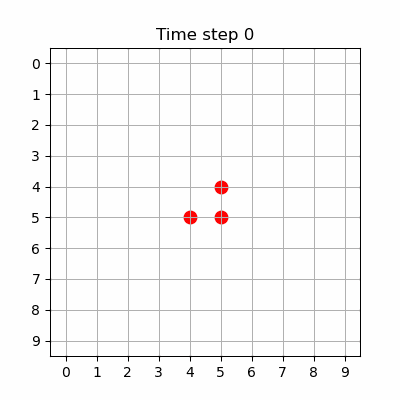

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import Image, display

# -----------------------
# Parameters
# -----------------------
H, W = 10, 10
n = H * W
T = 10
noise_level = 0

rng = np.random.default_rng(0)


Omega_rc = np.array([
    [H // 2,     W // 2],
    [H // 2 - 1, W // 2],
    [H // 2,     W // 2 - 1],
])

m = Omega_rc.shape[0]

print("Initial Omega_rc:", Omega_rc)

# -----------------------
# Helper functions
# -----------------------
def rc_to_idx(r, c):
    return r * W + c

def selector_from_rc(Omega_rc, H, W):
    n = H * W
    m = Omega_rc.shape[0]
    P = np.zeros((m, n))
    for row, (r, c) in enumerate(Omega_rc):
        idx = rc_to_idx(r, c)
        P[row, idx] = 1.0
    return P

def move_policy(Omega_rc, t, H, W):
    """
    Static policy:
    Robots do NOT move.
    """
    return Omega_rc.copy()

# -----------------------
# System definition
# -----------------------
G = rng.normal(scale=0.15, size=(n, n))

v0_true = rng.normal(size=n)
v0_true /= np.linalg.norm(v0_true)

# -----------------------
# Storage
# -----------------------
O_blocks = []
ys = []
positions = []

v_t = v0_true.copy()
G_power = np.eye(n)

# -----------------------
# Simulation loop
# -----------------------
for t in range(T + 1):

    # store robot positions (for visualization)
    positions.append(Omega_rc.copy())

    # selector matrix
    P_t = selector_from_rc(Omega_rc, H, W)

    # measurement
    y_t = P_t @ v_t + rng.normal(scale=noise_level, size=m)
    ys.append(y_t)

    # observability block
    if t == 0:
        O_blocks.append(P_t @ G_power)
    else:
        G_power = G_power @ G
        O_blocks.append(P_t @ G_power)

    # system evolution
    v_t = G @ v_t

    # robot motion (static)
    Omega_rc = move_policy(Omega_rc, t, H, W)

# -----------------------
# Stack & reconstruct
# -----------------------
y_stacked = np.concatenate(ys, axis=0)
O_T = np.vstack(O_blocks)

v0_hat, *_ = np.linalg.lstsq(O_T, y_stacked, rcond=None)
err = np.linalg.norm(v0_hat - v0_true)

print("Reconstruction error:", err)
print("rank(O_T):", np.linalg.matrix_rank(O_T))

# -----------------------
# Visualization (GIF)
# -----------------------
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlim(-0.5, W - 0.5)
ax.set_ylim(H - 0.5, -0.5)
ax.set_xticks(range(W))
ax.set_yticks(range(H))
ax.grid(True)

scat = ax.scatter([], [], s=80, c="red")

def init():
    scat.set_offsets(np.empty((0, 2)))
    return (scat,)

def update(frame):
    Omega = positions[frame]
    xy = np.column_stack([Omega[:, 1], Omega[:, 0]])  # (x=col, y=row)
    scat.set_offsets(xy)
    ax.set_title(f"Time step {frame}")
    return (scat,)

ani = animation.FuncAnimation(
    fig,
    update,
    frames=len(positions),
    init_func=init,
    interval=500,
    blit=True
)

gif_path = "robot_static.gif"
ani.save(gif_path, writer=animation.PillowWriter(fps=2))
plt.close(fig)

display(Image(filename=gif_path))


### 5 Sensors Stationary

Initial Omega_rc: [[9 9]
 [4 5]
 [0 0]
 [9 0]
 [0 9]]
Reconstruction error: 0.7007975434791028
rank(O_T): 55


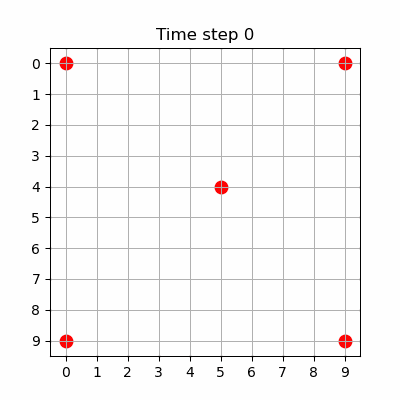

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import Image, display

# -----------------------
# Parameters
# -----------------------
H, W = 10, 10
n = H * W
T = 10
noise_level = 0

rng = np.random.default_rng(0)


Omega_rc = np.array([
    [H - 1,     W - 1],
    [H // 2 - 1, W // 2],
    [H - 10,     W - 10],
    [H-1, W-10],
    [H-10, W-1]
])

m = Omega_rc.shape[0]

print("Initial Omega_rc:", Omega_rc)

# -----------------------
# Helper functions
# -----------------------
def rc_to_idx(r, c):
    return r * W + c

def selector_from_rc(Omega_rc, H, W):
    n = H * W
    m = Omega_rc.shape[0]
    P = np.zeros((m, n))
    for row, (r, c) in enumerate(Omega_rc):
        idx = rc_to_idx(r, c)
        P[row, idx] = 1.0
    return P

def move_policy(Omega_rc, t, H, W):
    """
    Static policy:
    Robots do NOT move.
    """
    return Omega_rc.copy()

# -----------------------
# System definition
# -----------------------
G = rng.normal(scale=0.15, size=(n, n))

v0_true = rng.normal(size=n)
v0_true /= np.linalg.norm(v0_true)

# -----------------------
# Storage
# -----------------------
O_blocks = []
ys = []
positions = []

v_t = v0_true.copy()
G_power = np.eye(n)

# -----------------------
# Simulation loop
# -----------------------
for t in range(T + 1):

    # store robot positions (for visualization)
    positions.append(Omega_rc.copy())

    # selector matrix
    P_t = selector_from_rc(Omega_rc, H, W)

    # measurement
    y_t = P_t @ v_t + rng.normal(scale=noise_level, size=m)
    ys.append(y_t)

    # observability block
    if t == 0:
        O_blocks.append(P_t @ G_power)
    else:
        G_power = G_power @ G
        O_blocks.append(P_t @ G_power)

    # system evolution
    v_t = G @ v_t

    # robot motion (static)
    Omega_rc = move_policy(Omega_rc, t, H, W)

# -----------------------
# Stack & reconstruct
# -----------------------
y_stacked = np.concatenate(ys, axis=0)
O_T = np.vstack(O_blocks)

v0_hat, *_ = np.linalg.lstsq(O_T, y_stacked, rcond=None)
err = np.linalg.norm(v0_hat - v0_true)

print("Reconstruction error:", err)
print("rank(O_T):", np.linalg.matrix_rank(O_T))

# -----------------------
# Visualization (GIF)
# -----------------------
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlim(-0.5, W - 0.5)
ax.set_ylim(H - 0.5, -0.5)
ax.set_xticks(range(W))
ax.set_yticks(range(H))
ax.grid(True)

scat = ax.scatter([], [], s=80, c="red")

def init():
    scat.set_offsets(np.empty((0, 2)))
    return (scat,)

def update(frame):
    Omega = positions[frame]
    xy = np.column_stack([Omega[:, 1], Omega[:, 0]])  # (x=col, y=row)
    scat.set_offsets(xy)
    ax.set_title(f"Time step {frame}")
    return (scat,)

ani = animation.FuncAnimation(
    fig,
    update,
    frames=len(positions),
    init_func=init,
    interval=500,
    blit=True
)

gif_path = "robot_static.gif"
ani.save(gif_path, writer=animation.PillowWriter(fps=2))
plt.close(fig)

display(Image(filename=gif_path))


Initial Omega_rc: [[9 9]
 [4 5]
 [0 0]
 [9 0]
 [0 9]]
Reconstruction error: 6.728094552269305e-07
rank(O_T): 100


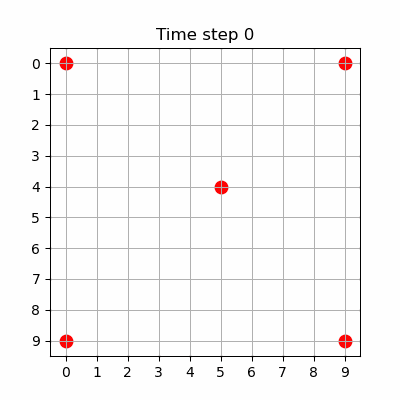

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import Image, display

# -----------------------
# Parameters
# -----------------------
H, W = 10, 10
n = H * W
T = 50
noise_level = 0

rng = np.random.default_rng(0)


Omega_rc = np.array([
    [H - 1,     W - 1],
    [H // 2 - 1, W // 2],
    [H - 10,     W - 10],
    [H-1, W-10],
    [H-10, W-1]
])

m = Omega_rc.shape[0]

print("Initial Omega_rc:", Omega_rc)

# -----------------------
# Helper functions
# -----------------------
def rc_to_idx(r, c):
    return r * W + c

def selector_from_rc(Omega_rc, H, W):
    n = H * W
    m = Omega_rc.shape[0]
    P = np.zeros((m, n))
    for row, (r, c) in enumerate(Omega_rc):
        idx = rc_to_idx(r, c)
        P[row, idx] = 1.0
    return P

def move_policy(Omega_rc, t, H, W):
    """
    Static policy:
    Robots do NOT move.
    """
    return Omega_rc.copy()

# -----------------------
# System definition
# -----------------------
G = rng.normal(scale=0.15, size=(n, n))

v0_true = rng.normal(size=n)
v0_true /= np.linalg.norm(v0_true)

# -----------------------
# Storage
# -----------------------
O_blocks = []
ys = []
positions = []

v_t = v0_true.copy()
G_power = np.eye(n)

# -----------------------
# Simulation loop
# -----------------------
for t in range(T + 1):

    # store robot positions (for visualization)
    positions.append(Omega_rc.copy())

    # selector matrix
    P_t = selector_from_rc(Omega_rc, H, W)

    # measurement
    y_t = P_t @ v_t + rng.normal(scale=noise_level, size=m)
    ys.append(y_t)

    # observability block
    if t == 0:
        O_blocks.append(P_t @ G_power)
    else:
        G_power = G_power @ G
        O_blocks.append(P_t @ G_power)

    # system evolution
    v_t = G @ v_t

    # robot motion (static)
    Omega_rc = move_policy(Omega_rc, t, H, W)

# -----------------------
# Stack & reconstruct
# -----------------------
y_stacked = np.concatenate(ys, axis=0)
O_T = np.vstack(O_blocks)

v0_hat, *_ = np.linalg.lstsq(O_T, y_stacked, rcond=None)
err = np.linalg.norm(v0_hat - v0_true)

print("Reconstruction error:", err)
print("rank(O_T):", np.linalg.matrix_rank(O_T))

# -----------------------
# Visualization (GIF)
# -----------------------
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlim(-0.5, W - 0.5)
ax.set_ylim(H - 0.5, -0.5)
ax.set_xticks(range(W))
ax.set_yticks(range(H))
ax.grid(True)

scat = ax.scatter([], [], s=80, c="red")

def init():
    scat.set_offsets(np.empty((0, 2)))
    return (scat,)

def update(frame):
    Omega = positions[frame]
    xy = np.column_stack([Omega[:, 1], Omega[:, 0]])  # (x=col, y=row)
    scat.set_offsets(xy)
    ax.set_title(f"Time step {frame}")
    return (scat,)

ani = animation.FuncAnimation(
    fig,
    update,
    frames=len(positions),
    init_func=init,
    interval=500,
    blit=True
)

gif_path = "robot_static.gif"
ani.save(gif_path, writer=animation.PillowWriter(fps=2))
plt.close(fig)

display(Image(filename=gif_path))


Initial Omega_rc: [[0 9]]
Reconstruction error: 0.8323963725102935
rank(O_T): 37


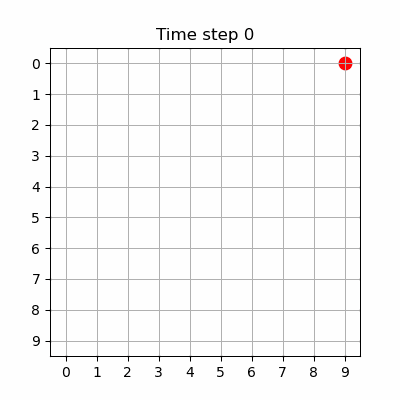

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import Image, display

# -----------------------
# Parameters
# -----------------------
H, W = 10, 10
n = H * W
T = 100
noise_level = 0

rng = np.random.default_rng(0)


Omega_rc = np.array([
    [0, W - 1],
])

m = Omega_rc.shape[0]

print("Initial Omega_rc:", Omega_rc)

# -----------------------
# Helper functions
# -----------------------
def rc_to_idx(r, c):
    return r * W + c

def selector_from_rc(Omega_rc, H, W):
    n = H * W
    m = Omega_rc.shape[0]
    P = np.zeros((m, n))
    for row, (r, c) in enumerate(Omega_rc):
        idx = rc_to_idx(r, c)
        P[row, idx] = 1.0
    return P

def move_policy(Omega_rc, t, H, W):
    """
    Zig-zag motion from top-right toward bottom-left.
    All robots follow the same zig-zag pattern.
    """
    Omega_next = Omega_rc.copy()

    # zig-zag direction depends on row parity
    for i, (r, c) in enumerate(Omega_rc):

        # even rows: move left
        if r % 2 == 0:
            c_new = c - 1
            if c_new < 0:
                r = min(r + 1, H - 1)   # move down
                c_new = 0               # stay at boundary
        # odd rows: move right
        else:
            c_new = c + 1
            if c_new >= W:
                r = min(r + 1, H - 1)   # move down
                c_new = W - 1           # stay at boundary

        Omega_next[i] = [r, c_new]

    return Omega_next


# -----------------------
# System definition
# -----------------------
G = rng.normal(scale=0.15, size=(n, n))

v0_true = rng.normal(size=n)
v0_true /= np.linalg.norm(v0_true)

# -----------------------
# Storage
# -----------------------
O_blocks = []
ys = []
positions = []

v_t = v0_true.copy()
G_power = np.eye(n)

# -----------------------
# Simulation loop
# -----------------------
for t in range(T + 1):

    # store robot positions (for visualization)
    positions.append(Omega_rc.copy())

    # selector matrix
    P_t = selector_from_rc(Omega_rc, H, W)

    # measurement
    y_t = P_t @ v_t + rng.normal(scale=noise_level, size=m)
    ys.append(y_t)

    # observability block
    if t == 0:
        O_blocks.append(P_t @ G_power)
    else:
        G_power = G_power @ G
        O_blocks.append(P_t @ G_power)

    # system evolution
    v_t = G @ v_t

    # robot motion (static)
    Omega_rc = move_policy(Omega_rc, t, H, W)

# -----------------------
# Stack & reconstruct
# -----------------------
y_stacked = np.concatenate(ys, axis=0)
O_T = np.vstack(O_blocks)

v0_hat, *_ = np.linalg.lstsq(O_T, y_stacked, rcond=None)
err = np.linalg.norm(v0_hat - v0_true)

print("Reconstruction error:", err)
print("rank(O_T):", np.linalg.matrix_rank(O_T))

# -----------------------
# Visualization (GIF)
# -----------------------
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlim(-0.5, W - 0.5)
ax.set_ylim(H - 0.5, -0.5)
ax.set_xticks(range(W))
ax.set_yticks(range(H))
ax.grid(True)

scat = ax.scatter([], [], s=80, c="red")

def init():
    scat.set_offsets(np.empty((0, 2)))
    return (scat,)

def update(frame):
    Omega = positions[frame]
    xy = np.column_stack([Omega[:, 1], Omega[:, 0]])  # (x=col, y=row)
    scat.set_offsets(xy)
    ax.set_title(f"Time step {frame}")
    return (scat,)

ani = animation.FuncAnimation(
    fig,
    update,
    frames=len(positions),
    init_func=init,
    interval=500,
    blit=True
)

gif_path = "robot_static.gif"
ani.save(gif_path, writer=animation.PillowWriter(fps=2))
plt.close(fig)

display(Image(filename=gif_path))


### Two Robotos Move Diagonaly

Initial Omega_rc: [[0 9]
 [9 0]]
Reconstruction error: 0.9197835361559625
rank(O_T): 22


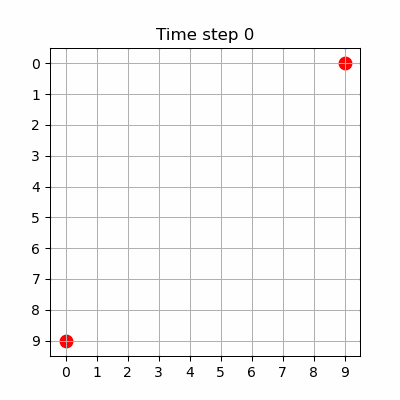

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import Image, display

# -----------------------
# Parameters
# -----------------------
H, W = 10, 10
n = H * W
T = 10
noise_level = 0

rng = np.random.default_rng(0)


Omega_rc = np.array([
    [0, W - 1],
    [W - 1, 0]
])

m = Omega_rc.shape[0]

print("Initial Omega_rc:", Omega_rc)

# -----------------------
# Helper functions
# -----------------------
def rc_to_idx(r, c):
    return r * W + c

def selector_from_rc(Omega_rc, H, W):
    n = H * W
    m = Omega_rc.shape[0]
    P = np.zeros((m, n))
    for row, (r, c) in enumerate(Omega_rc):
        idx = rc_to_idx(r, c)
        P[row, idx] = 1.0
    return P

def move_policy(Omega_rc, t, H, W):
    """
    Two-robot diagonal motion:
    - Robot 0: top-right -> bottom-left  (down + left)
    - Robot 1: bottom-left -> top-right  (up + right)
    """
    Omega_next = Omega_rc.copy()

    # Robot 0: down-left
    Omega_next[0, 0] = np.clip(Omega_rc[0, 0] + 1, 0, H - 1)  # row + 1
    Omega_next[0, 1] = np.clip(Omega_rc[0, 1] - 1, 0, W - 1)  # col - 1

    # Robot 1: up-right
    Omega_next[1, 0] = np.clip(Omega_rc[1, 0] - 1, 0, H - 1)  # row - 1
    Omega_next[1, 1] = np.clip(Omega_rc[1, 1] + 1, 0, W - 1)  # col + 1

    return Omega_next


# -----------------------
# System definition
# -----------------------
G = rng.normal(scale=0.15, size=(n, n))

v0_true = rng.normal(size=n)
v0_true /= np.linalg.norm(v0_true)

# -----------------------
# Storage
# -----------------------
O_blocks = []
ys = []
positions = []

v_t = v0_true.copy()
G_power = np.eye(n)

# -----------------------
# Simulation loop
# -----------------------
for t in range(T + 1):

    # store robot positions (for visualization)
    positions.append(Omega_rc.copy())

    # selector matrix
    P_t = selector_from_rc(Omega_rc, H, W)

    # measurement
    y_t = P_t @ v_t + rng.normal(scale=noise_level, size=m)
    ys.append(y_t)

    # observability block
    if t == 0:
        O_blocks.append(P_t @ G_power)
    else:
        G_power = G_power @ G
        O_blocks.append(P_t @ G_power)

    # system evolution
    v_t = G @ v_t

    # robot motion (static)
    Omega_rc = move_policy(Omega_rc, t, H, W)

# -----------------------
# Stack & reconstruct
# -----------------------
y_stacked = np.concatenate(ys, axis=0)
O_T = np.vstack(O_blocks)

v0_hat, *_ = np.linalg.lstsq(O_T, y_stacked, rcond=None)
err = np.linalg.norm(v0_hat - v0_true)

print("Reconstruction error:", err)
print("rank(O_T):", np.linalg.matrix_rank(O_T))

# -----------------------
# Visualization (GIF)
# -----------------------
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlim(-0.5, W - 0.5)
ax.set_ylim(H - 0.5, -0.5)
ax.set_xticks(range(W))
ax.set_yticks(range(H))
ax.grid(True)

scat = ax.scatter([], [], s=80, c="red")

def init():
    scat.set_offsets(np.empty((0, 2)))
    return (scat,)

def update(frame):
    Omega = positions[frame]
    xy = np.column_stack([Omega[:, 1], Omega[:, 0]])  # (x=col, y=row)
    scat.set_offsets(xy)
    ax.set_title(f"Time step {frame}")
    return (scat,)

ani = animation.FuncAnimation(
    fig,
    update,
    frames=len(positions),
    init_func=init,
    interval=500,
    blit=True
)

gif_path = "robot_static.gif"
ani.save(gif_path, writer=animation.PillowWriter(fps=2))
plt.close(fig)

display(Image(filename=gif_path))


### Two Robots move reversely

Initial Omega_rc: [[0 9]
 [9 0]
 [5 5]]
Reconstruction error: 0.8610179311987516
rank(O_T): 24


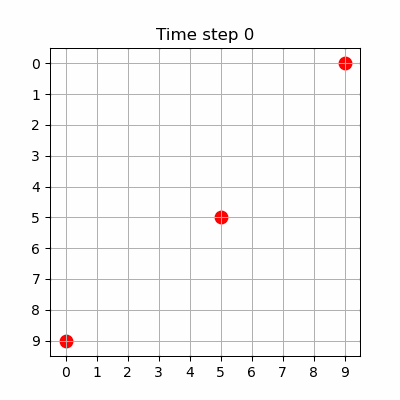

In [119]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import Image, display

# -----------------------
# Parameters
# -----------------------
H, W = 10, 10
n = H * W
T = 200
noise_level = 0

rng = np.random.default_rng(0)


Omega_rc = np.array([
    [0, W - 1],
    [H - 1, 0],
    [H//2, W//2]
])

m = Omega_rc.shape[0]

print("Initial Omega_rc:", Omega_rc)

# -----------------------
# Helper functions
# -----------------------
def rc_to_idx(r, c):
    return r * W + c

def selector_from_rc(Omega_rc, H, W):
    n = H * W
    m = Omega_rc.shape[0]
    P = np.zeros((m, n))
    for row, (r, c) in enumerate(Omega_rc):
        idx = rc_to_idx(r, c)
        P[row, idx] = 1.0
    return P

def move_policy(Omega_rc, t, H, W):
    """
    Two robots:
    - Robot 0: original zig-zag
    - Robot 1: reversed zig-zag
    """
    Omega_next = Omega_rc.copy()

    for i, (r, c) in enumerate(Omega_rc):

        # ---------- Robot 0: ORIGINAL zig-zag ----------
        if i == 0:
            if r % 2 == 0:  # even rows → move left
                c_new = c - 1
                if c_new < 0:
                    r = min(r + 1, H - 1)
                    c_new = 0
            else:           # odd rows → move right
                c_new = c + 1
                if c_new >= W:
                    r = min(r + 1, H - 1)
                    c_new = W - 1

        # ---------- Robot 1: REVERSED zig-zag ----------
        else:
            if r % 2 == 0:  # even rows → move right
                c_new = c + 1
                if c_new >= W:
                    r = max(r - 1, 0)
                    c_new = W - 1
            else:           # odd rows → move left
                c_new = c - 1
                if c_new < 0:
                    r = max(r - 1, 0)
                    c_new = 0

        Omega_next[i] = [r, c_new]

    return Omega_next



# -----------------------
# System definition
# -----------------------
G = rng.normal(scale=0.15, size=(n, n))
G = G / np.linalg.norm(G)
G = G @ G.T

v0_true = rng.normal(size=n)
v0_true /= np.linalg.norm(v0_true)

# -----------------------
# Storage
# -----------------------
O_blocks = []
ys = []
positions = []

v_t = v0_true.copy()
G_power = np.eye(n)

# -----------------------
# Simulation loop
# -----------------------
for t in range(T + 1):

    # store robot positions (for visualization)
    positions.append(Omega_rc.copy())

    # selector matrix
    P_t = selector_from_rc(Omega_rc, H, W)

    # measurement
    y_t = P_t @ v_t + rng.normal(scale=noise_level, size=m)
    ys.append(y_t)

    # observability block
    if t == 0:
        O_blocks.append(P_t @ G_power)
    else:
        G_power = G_power @ G
        O_blocks.append(P_t @ G_power)

    # system evolution
    v_t = G @ v_t

    # robot motion (static)
    Omega_rc = move_policy(Omega_rc, t, H, W)

# -----------------------
# Stack & reconstruct
# -----------------------
y_stacked = np.concatenate(ys, axis=0)
O_T = np.vstack(O_blocks)

v0_hat, *_ = np.linalg.lstsq(O_T, y_stacked, rcond=None)
err = np.linalg.norm(v0_hat - v0_true)

print("Reconstruction error:", err)
print("rank(O_T):", np.linalg.matrix_rank(O_T))

# -----------------------
# Visualization (GIF)
# -----------------------
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlim(-0.5, W - 0.5)
ax.set_ylim(H - 0.5, -0.5)
ax.set_xticks(range(W))
ax.set_yticks(range(H))
ax.grid(True)

scat = ax.scatter([], [], s=80, c="red")

def init():
    scat.set_offsets(np.empty((0, 2)))
    return (scat,)

def update(frame):
    Omega = positions[frame]
    xy = np.column_stack([Omega[:, 1], Omega[:, 0]])  # (x=col, y=row)
    scat.set_offsets(xy)
    ax.set_title(f"Time step {frame}")
    return (scat,)

ani = animation.FuncAnimation(
    fig,
    update,
    frames=len(positions),
    init_func=init,
    interval=500,
    blit=True
)

gif_path = "robot_static.gif"
ani.save(gif_path, writer=animation.PillowWriter(fps=2))
plt.close(fig)

display(Image(filename=gif_path))



Initial Omega_rc:
 [[0 0]]
13
13
(201, 100)
Reconstruction error: 0.9713363589257676
rank(O_T): 7 / 100


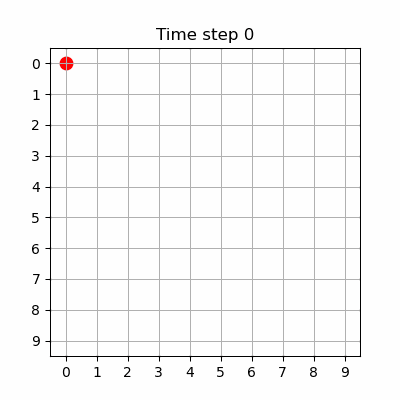

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import Image, display

# -----------------------
# Parameters
# -----------------------
H, W = 10, 10
n = H * W
m = 1
T = 200
noise_level = 0

rng = np.random.default_rng(0)

# -----------------------
# Initial robot positions (spread across top row)
# -----------------------
cols = np.linspace(0, W - 1, m, dtype=int)
Omega_rc = np.column_stack([
    np.zeros(m, dtype=int),  # start at top row
    cols
])

print("Initial Omega_rc:\n", Omega_rc)

# -----------------------
# Helper functions
# -----------------------
def rc_to_idx(r, c):
    return r * W + c

def selector_from_rc(Omega_rc, H, W):
    P = np.zeros((Omega_rc.shape[0], H * W))
    for i, (r, c) in enumerate(Omega_rc):
        P[i, rc_to_idx(r, c)] = 1.0
    return P

def move_policy(Omega_rc, t, H, W):
    """
    Serpentine (lawn-mower) sweep:
    - Even rows: move right
    - Odd rows: move left
    - Wrap horizontally; move down when row finishes
    """
    Omega_next = Omega_rc.copy()

    for i, (r, c) in enumerate(Omega_rc):
        if r % 2 == 0:  # even row → move right
            c_new = c + 1
            if c_new >= W:
                c_new = W - 1
                r = (r + 1) % H
        else:           # odd row → move left
            c_new = c - 1
            if c_new < 0:
                c_new = 0
                r = (r + 1) % H

        Omega_next[i] = [r, c_new]

    return Omega_next

# -----------------------
# System definition
# -----------------------
G = rng.normal(scale=0.15, size=(n, n))
#print(np.linalg.eigvals(G))
G = G / np.linalg.norm(G)


v0_true = rng.normal(size=n)
v0_true /= np.linalg.norm(v0_true)

# -----------------------
# Storage
# -----------------------
O_blocks = []
ys = []
positions = []

v_t = v0_true.copy()
G_power = np.eye(n)

# -----------------------
# Simulation loop
# -----------------------

for t in range(T + 1):

    positions.append(Omega_rc.copy())

    P_t = selector_from_rc(Omega_rc, H, W)
    y_t = P_t @ v_t + rng.normal(scale=noise_level, size=m)
    ys.append(y_t)

    if t == 0:
        O_blocks.append(P_t @ G_power)
    else:
        G_power = G_power @ G
        O_blocks.append(P_t @ G_power)
        
    #print(np.linalg.matrix_rank(P_t @ G_power))
    v_t = G @ v_t
    Omega_rc = move_policy(Omega_rc, t, H, W)

O_T = np.vstack(O_blocks)

for t in range(T + 1, T + 50):

    positions.append(Omega_rc.copy())

    P_t = selector_from_rc(Omega_rc, H, W)
    y_t = P_t @ v_t + rng.normal(scale=noise_level, size=m)
    ys.append(y_t)

    if t == 0:
        O_blocks.append(P_t @ G_power)
    else:
        G_power = G_power @ G
        O_blocks.append(P_t @ G_power)
        
    #print(np.linalg.matrix_rank(P_t @ G_power))
    v_t = G @ v_t
    Omega_rc = move_policy(Omega_rc, t, H, W)
    

# -----------------------
# Stack & reconstruct
# -----------------------
y_stacked = np.concatenate(ys, axis=0)
O_T1 = np.vstack(O_blocks)
print(np.linalg.matrix_rank(O_T))
print(np.linalg.matrix_rank(O_T1))
print(O_T.shape)

v0_hat, *_ = np.linalg.lstsq(O_T1, y_stacked, rcond=None)
err = np.linalg.norm(v0_hat - v0_true)

print("Reconstruction error:", err)
print("rank(O_T):", np.linalg.matrix_rank(O_T.T @ O_T), "/", n)

# -----------------------
# Visualization (GIF)
# -----------------------
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlim(-0.5, W - 0.5)
ax.set_ylim(H - 0.5, -0.5)
ax.set_xticks(range(W))
ax.set_yticks(range(H))
ax.grid(True)

scat = ax.scatter([], [], s=80, c="red")

def init():
    scat.set_offsets(np.empty((0, 2)))
    return (scat,)

def update(frame):
    Omega = positions[frame]
    scat.set_offsets(np.column_stack([Omega[:, 1], Omega[:, 0]]))
    ax.set_title(f"Time step {frame}")
    return (scat,)

ani = animation.FuncAnimation(
    fig,
    update,
    frames=len(positions),
    init_func=init,
    interval=200,
    blit=True
)

gif_path = "serpentine_m5_T60.gif"
ani.save(gif_path, writer=animation.PillowWriter(fps=5))
plt.close(fig)

display(Image(filename=gif_path))


Initial Omega_rc:
 [[0 0]
 [0 2]
 [0 4]
 [0 6]
 [0 9]]
Reconstruction error: 1.3742715908599375e-06
rank(O_T): 100 / 100


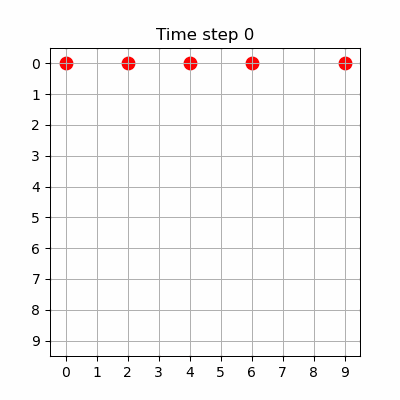

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import Image, display

# -----------------------
# Parameters
# -----------------------
H, W = 10, 10
n = H * W
m = 5
T = 50
noise_level = 0.0

rng = np.random.default_rng(0)

# -----------------------
# Initial robot positions (spread across top row)
# -----------------------
cols = np.linspace(0, W - 1, m, dtype=int)
Omega_rc = np.column_stack([
    np.zeros(m, dtype=int),  # start at top row
    cols
])

print("Initial Omega_rc:\n", Omega_rc)

# -----------------------
# Helper functions
# -----------------------
def rc_to_idx(r, c):
    return r * W + c

def selector_from_rc(Omega_rc, H, W):
    P = np.zeros((Omega_rc.shape[0], H * W))
    for i, (r, c) in enumerate(Omega_rc):
        P[i, rc_to_idx(r, c)] = 1.0
    return P

def move_policy(Omega_rc, t, H, W):
    """
    Serpentine (lawn-mower) sweep:
    - Even rows: move right
    - Odd rows: move left
    - Wrap horizontally; move down when row finishes
    """
    Omega_next = Omega_rc.copy()

    for i, (r, c) in enumerate(Omega_rc):
        if r % 2 == 0:  # even row → move right
            c_new = c + 1
            if c_new >= W:
                c_new = W - 1
                r = (r + 1) % H
        else:           # odd row → move left
            c_new = c - 1
            if c_new < 0:
                c_new = 0
                r = (r + 1) % H

        Omega_next[i] = [r, c_new]

    return Omega_next

# -----------------------
# System definition
# -----------------------
G = rng.normal(scale=0.15, size=(n, n))

v0_true = rng.normal(size=n)
v0_true /= np.linalg.norm(v0_true)

# -----------------------
# Storage
# -----------------------
O_blocks = []
ys = []
positions = []

v_t = v0_true.copy()
G_power = np.eye(n)

# -----------------------
# Simulation loop
# -----------------------
for t in range(T + 1):

    positions.append(Omega_rc.copy())

    P_t = selector_from_rc(Omega_rc, H, W)
    y_t = P_t @ v_t + rng.normal(scale=noise_level, size=m)
    ys.append(y_t)

    if t == 0:
        O_blocks.append(P_t @ G_power)
    else:
        G_power = G_power @ G
        O_blocks.append(P_t @ G_power)

    v_t = G @ v_t
    Omega_rc = move_policy(Omega_rc, t, H, W)

# -----------------------
# Stack & reconstruct
# -----------------------
y_stacked = np.concatenate(ys, axis=0)
O_T = np.vstack(O_blocks)

v0_hat, *_ = np.linalg.lstsq(O_T, y_stacked, rcond=None)
err = np.linalg.norm(v0_hat - v0_true)

print("Reconstruction error:", err)
print("rank(O_T):", np.linalg.matrix_rank(O_T), "/", n)

# -----------------------
# Visualization (GIF)
# -----------------------
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlim(-0.5, W - 0.5)
ax.set_ylim(H - 0.5, -0.5)
ax.set_xticks(range(W))
ax.set_yticks(range(H))
ax.grid(True)

scat = ax.scatter([], [], s=80, c="red")

def init():
    scat.set_offsets(np.empty((0, 2)))
    return (scat,)

def update(frame):
    Omega = positions[frame]
    scat.set_offsets(np.column_stack([Omega[:, 1], Omega[:, 0]]))
    ax.set_title(f"Time step {frame}")
    return (scat,)

ani = animation.FuncAnimation(
    fig,
    update,
    frames=len(positions),
    init_func=init,
    interval=200,
    blit=True
)

gif_path = "serpentine_m5_T60.gif"
ani.save(gif_path, writer=animation.PillowWriter(fps=5))
plt.close(fig)

display(Image(filename=gif_path))


### Random Walk

Initial Omega_rc:
 [[0 0]
 [0 9]
 [9 0]
 [9 9]
 [5 5]]
Reconstruction error: 1.2133505977284042e-06
rank(O_T): 100 / 100


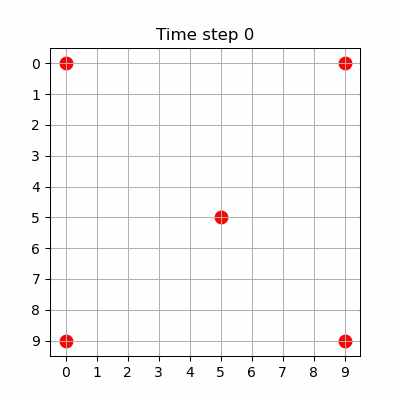

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import Image, display

# -----------------------
# Parameters
# -----------------------
H, W = 10, 10
n = H * W
m = 5
T = 50
noise_level = 0

rng = np.random.default_rng(0)

# -----------------------
# Initial robot positions (spread across grid)
# -----------------------
Omega_rc = np.array([
    [0, 0],
    [0, W - 1],
    [H - 1, 0],
    [H - 1, W - 1],
    [H // 2, W // 2],
])

print("Initial Omega_rc:\n", Omega_rc)

# -----------------------
# Helper functions
# -----------------------
def rc_to_idx(r, c):
    return r * W + c

def selector_from_rc(Omega_rc, H, W):
    P = np.zeros((Omega_rc.shape[0], H * W))
    for i, (r, c) in enumerate(Omega_rc):
        P[i, rc_to_idx(r, c)] = 1.0
    return P

def move_policy(Omega_rc, t, H, W):
    """
    Random walk with reflection at boundaries.
    Each robot independently moves: up, down, left, right, or stay.
    """
    Omega_next = Omega_rc.copy()

    for i, (r, c) in enumerate(Omega_rc):
        dr, dc = rng.choice([
            (0, 0),   # stay
            (1, 0),   # down
            (-1, 0),  # up
            (0, 1),   # right
            (0, -1),  # left
        ])

        r_new = r + dr
        c_new = c + dc

        # reflect at boundaries
        r_new = min(max(r_new, 0), H - 1)
        c_new = min(max(c_new, 0), W - 1)

        Omega_next[i] = [r_new, c_new]

    return Omega_next

# -----------------------
# System definition
# -----------------------
G = rng.normal(scale=0.15, size=(n, n))

v0_true = rng.normal(size=n)
v0_true /= np.linalg.norm(v0_true)

# -----------------------
# Storage
# -----------------------
O_blocks = []
ys = []
positions = []

v_t = v0_true.copy()
G_power = np.eye(n)

# -----------------------
# Simulation loop
# -----------------------
for t in range(T + 1):

    positions.append(Omega_rc.copy())

    P_t = selector_from_rc(Omega_rc, H, W)
    y_t = P_t @ v_t + rng.normal(scale=noise_level, size=m)
    ys.append(y_t)

    if t == 0:
        O_blocks.append(P_t @ G_power)
    else:
        G_power = G_power @ G
        O_blocks.append(P_t @ G_power)

    v_t = G @ v_t
    Omega_rc = move_policy(Omega_rc, t, H, W)

# -----------------------
# Stack & reconstruct
# -----------------------
y_stacked = np.concatenate(ys, axis=0)
O_T = np.vstack(O_blocks)

v0_hat, *_ = np.linalg.lstsq(O_T, y_stacked, rcond=None)
err = np.linalg.norm(v0_hat - v0_true)

print("Reconstruction error:", err)
print("rank(O_T):", np.linalg.matrix_rank(O_T), "/", n)

# -----------------------
# Visualization (GIF)
# -----------------------
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlim(-0.5, W - 0.5)
ax.set_ylim(H - 0.5, -0.5)
ax.set_xticks(range(W))
ax.set_yticks(range(H))
ax.grid(True)

scat = ax.scatter([], [], s=80, c="red")

def init():
    scat.set_offsets(np.empty((0, 2)))
    return (scat,)

def update(frame):
    Omega = positions[frame]
    scat.set_offsets(np.column_stack([Omega[:, 1], Omega[:, 0]]))
    ax.set_title(f"Time step {frame}")
    return (scat,)

ani = animation.FuncAnimation(
    fig,
    update,
    frames=len(positions),
    init_func=init,
    interval=150,
    blit=True
)

gif_path = "random_walk_m5_T100.gif"
ani.save(gif_path, writer=animation.PillowWriter(fps=6))
plt.close(fig)

display(Image(filename=gif_path))


Initial Omega_rc:
 [[0 0]
 [0 9]
 [9 0]
 [9 9]
 [5 5]]
Reconstruction error: 0.750564806508225
rank(O_T): 37 / 100


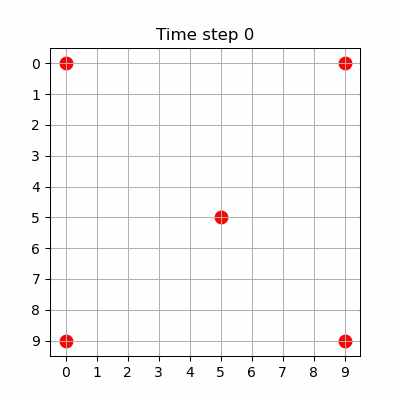

In [121]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import Image, display

# -----------------------
# Parameters
# -----------------------
H, W = 10, 10
n = H * W
m = 5
T = 100
noise_level = 0

rng = np.random.default_rng(0)

# -----------------------
# Initial robot positions (spread across grid)
# -----------------------
Omega_rc = np.array([
    [0, 0],
    [0, W - 1],
    [H - 1, 0],
    [H - 1, W - 1],
    [H // 2, W // 2],
])

print("Initial Omega_rc:\n", Omega_rc)

# -----------------------
# Helper functions
# -----------------------
def rc_to_idx(r, c):
    return r * W + c

def selector_from_rc(Omega_rc, H, W):
    P = np.zeros((Omega_rc.shape[0], H * W))
    for i, (r, c) in enumerate(Omega_rc):
        P[i, rc_to_idx(r, c)] = 1.0
    return P

def move_policy(Omega_rc, t, H, W):
    """
    Random walk with reflection at boundaries.
    Each robot independently moves: up, down, left, right, or stay.
    """
    Omega_next = Omega_rc.copy()

    for i, (r, c) in enumerate(Omega_rc):
        dr, dc = rng.choice([
            (0, 0),   # stay
            (1, 0),   # down
            (-1, 0),  # up
            (0, 1),   # right
            (0, -1),  # left
        ])

        r_new = r + dr
        c_new = c + dc

        # reflect at boundaries
        r_new = min(max(r_new, 0), H - 1)
        c_new = min(max(c_new, 0), W - 1)

        Omega_next[i] = [r_new, c_new]

    return Omega_next

# -----------------------
# System definition
# -----------------------
G = rng.normal(scale=0.15, size=(n, n))
G = G / np.linalg.norm(G)
G = G @ G.T

v0_true = rng.normal(size=n)
v0_true /= np.linalg.norm(v0_true)

# -----------------------
# Storage
# -----------------------
O_blocks = []
ys = []
positions = []

v_t = v0_true.copy()
G_power = np.eye(n)

# -----------------------
# Simulation loop
# -----------------------
for t in range(T + 1):

    positions.append(Omega_rc.copy())

    P_t = selector_from_rc(Omega_rc, H, W)
    y_t = P_t @ v_t + rng.normal(scale=noise_level, size=m)
    ys.append(y_t)

    if t == 0:
        O_blocks.append(P_t @ G_power)
    else:
        G_power = G_power @ G
        O_blocks.append(P_t @ G_power)

    v_t = G @ v_t
    Omega_rc = move_policy(Omega_rc, t, H, W)

# -----------------------
# Stack & reconstruct
# -----------------------
y_stacked = np.concatenate(ys, axis=0)
O_T = np.vstack(O_blocks)

v0_hat, *_ = np.linalg.lstsq(O_T, y_stacked, rcond=None)
err = np.linalg.norm(v0_hat - v0_true)

print("Reconstruction error:", err)
print("rank(O_T):", np.linalg.matrix_rank(O_T), "/", n)

# -----------------------
# Visualization (GIF)
# -----------------------
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlim(-0.5, W - 0.5)
ax.set_ylim(H - 0.5, -0.5)
ax.set_xticks(range(W))
ax.set_yticks(range(H))
ax.grid(True)

scat = ax.scatter([], [], s=80, c="red")

def init():
    scat.set_offsets(np.empty((0, 2)))
    return (scat,)

def update(frame):
    Omega = positions[frame]
    scat.set_offsets(np.column_stack([Omega[:, 1], Omega[:, 0]]))
    ax.set_title(f"Time step {frame}")
    return (scat,)

ani = animation.FuncAnimation(
    fig,
    update,
    frames=len(positions),
    init_func=init,
    interval=150,
    blit=True
)

gif_path = "random_walk_m5_T100.gif"
ani.save(gif_path, writer=animation.PillowWriter(fps=6))
plt.close(fig)

display(Image(filename=gif_path))


Initial Omega_rc:
 [[0 0]
 [0 9]
 [9 0]
 [9 9]
 [5 5]
 [1 0]
 [1 8]
 [8 0]
 [8 9]
 [5 5]]
Reconstruction error: 0.5397467418891969
rank(O_T): 61 / 100


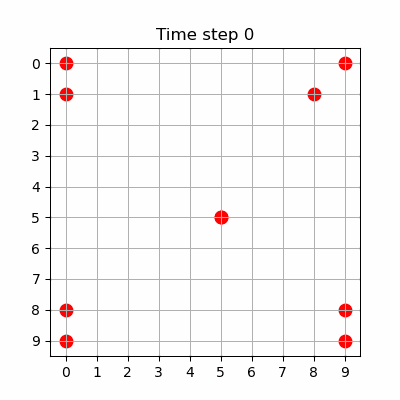

In [125]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import Image, display

# -----------------------
# Parameters
# -----------------------
H, W = 10, 10
n = H * W
m = 10
T = 100
noise_level = 0

rng = np.random.default_rng(0)

# -----------------------
# Initial robot positions (spread across grid)
# -----------------------
Omega_rc = np.array([
    [0, 0],
    [0, W - 1],
    [H - 1, 0],
    [H - 1, W - 1],
    [H // 2, W // 2],
    [1, 0],
    [1, W - 2],
    [H - 2, 0],
    [H - 2, W - 1],
    [H // 2, W // 2],
])

print("Initial Omega_rc:\n", Omega_rc)

# -----------------------
# Helper functions
# -----------------------
def rc_to_idx(r, c):
    return r * W + c

def selector_from_rc(Omega_rc, H, W):
    P = np.zeros((Omega_rc.shape[0], H * W))
    for i, (r, c) in enumerate(Omega_rc):
        P[i, rc_to_idx(r, c)] = 1.0
    return P

def move_policy(Omega_rc, t, H, W):
    """
    Random walk with reflection at boundaries.
    Each robot independently moves: up, down, left, right, or stay.
    """
    Omega_next = Omega_rc.copy()

    for i, (r, c) in enumerate(Omega_rc):
        dr, dc = rng.choice([
            (0, 0),   # stay
            (1, 0),   # down
            (-1, 0),  # up
            (0, 1),   # right
            (0, -1),  # left
        ])

        r_new = r + dr
        c_new = c + dc

        # reflect at boundaries
        r_new = min(max(r_new, 0), H - 1)
        c_new = min(max(c_new, 0), W - 1)

        Omega_next[i] = [r_new, c_new]

    return Omega_next

# -----------------------
# System definition
# -----------------------
G = rng.normal(scale=0.15, size=(n, n))
G = G / np.linalg.norm(G)
G = G @ G.T

v0_true = rng.normal(size=n)
v0_true /= np.linalg.norm(v0_true)

# -----------------------
# Storage
# -----------------------
O_blocks = []
ys = []
positions = []

v_t = v0_true.copy()
G_power = np.eye(n)

# -----------------------
# Simulation loop
# -----------------------
for t in range(T + 1):

    positions.append(Omega_rc.copy())

    P_t = selector_from_rc(Omega_rc, H, W)
    y_t = P_t @ v_t + rng.normal(scale=noise_level, size=m)
    ys.append(y_t)

    if t == 0:
        O_blocks.append(P_t @ G_power)
    else:
        G_power = G_power @ G
        O_blocks.append(P_t @ G_power)

    v_t = G @ v_t
    Omega_rc = move_policy(Omega_rc, t, H, W)

# -----------------------
# Stack & reconstruct
# -----------------------
y_stacked = np.concatenate(ys, axis=0)
O_T = np.vstack(O_blocks)

v0_hat, *_ = np.linalg.lstsq(O_T, y_stacked, rcond=None)
err = np.linalg.norm(v0_hat - v0_true)

print("Reconstruction error:", err)
print("rank(O_T):", np.linalg.matrix_rank(O_T), "/", n)

# -----------------------
# Visualization (GIF)
# -----------------------
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlim(-0.5, W - 0.5)
ax.set_ylim(H - 0.5, -0.5)
ax.set_xticks(range(W))
ax.set_yticks(range(H))
ax.grid(True)

scat = ax.scatter([], [], s=80, c="red")

def init():
    scat.set_offsets(np.empty((0, 2)))
    return (scat,)

def update(frame):
    Omega = positions[frame]
    scat.set_offsets(np.column_stack([Omega[:, 1], Omega[:, 0]]))
    ax.set_title(f"Time step {frame}")
    return (scat,)

ani = animation.FuncAnimation(
    fig,
    update,
    frames=len(positions),
    init_func=init,
    interval=150,
    blit=True
)

gif_path = "random_walk_m5_T100.gif"
ani.save(gif_path, writer=animation.PillowWriter(fps=6))
plt.close(fig)

display(Image(filename=gif_path))
